## Causal analysis of the interference in ABM output
First I will navigate to the `~/Project/output` folder

In [71]:
import os
os.getcwd()

'/home/untik/IDEAprojects/ABM_CausalInf/output'

Change directory to one directory level up in `/output'

In [72]:
def moveDir(currentDir, folderName):
    index = os.getcwd().find("python")
    return os.getcwd()[:39] + folderName

os.chdir(moveDir(os.getcwd, "output"))
os.getcwd()

'/home/untik/IDEAprojects/ABM_CausalInf/output'

Select one file and explore it. What are the params defined for this SIM?

In [73]:
import csv

filename = os.listdir()[1]

with open(filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        for element in row:
            print(element)
        break

numPatients=500
probInfected=0.005
probVaccine=0.005
lambda=0.3
contagion=2.0
infectiousness=2.0
sexOnInfection=2.0
sexOnVaccine=2.0
vaccineOnInfection=2.0
promiscuityPopulation=0.005
maxPartnerForce=5.0
randomForce=5.0
partnerForce=3.0


Lets open the whole dataframe:

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(filename, skiprows = 1)
df.head()

,step,agent,sex,vaccine,infection,degree,contagionDist,infectiousnessDist,indInterference
0,0,Patient_0,False,False,False,3,0.000000,0.052170,0.000000
1,0,Patient_1,False,False,False,1,0.107087,0.506327,0.214174
2,0,Patient_2,True,False,False,2,0.067127,0.296408,0.134254
3,0,Patient_3,True,False,False,3,0.000000,0.000000,0.000000
4,0,Patient_4,False,False,False,3,0.000000,0.300357,0.000000


What is the histogram of the `degree` column for the `step == 0`? 

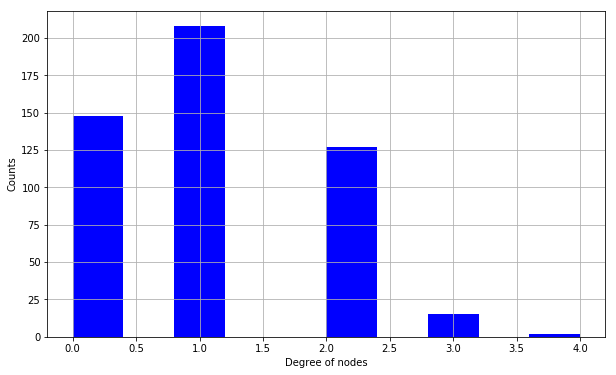

In [75]:
df[df.step == 5].degree.hist(figsize = (10,6), color = 'b')
plt.ylabel('Counts')
plt.xlabel('Degree of nodes')
plt.show()

## 1. Reorganise the dataFrame
The infectiousness and contagion do not affect the outcome in their current time but the outcome in a posterior time.
1. Create new, empty columns in the dataFrame: priorContagionDist, priorInfectiousnessDist, and priorIndInterference
2. Fill new columns with prior values of: contagionDist, infectiousnessDist, indInterference

In [76]:
newCols = ['priorContagionDist','priorInfectiousnessDist','priorIndInterference']

for i in newCols:
    df[i] = ""

df.head()

,step,agent,sex,vaccine,infection,degree,contagionDist,infectiousnessDist,indInterference,priorContagionDist,priorInfectiousnessDist,priorIndInterference
0,0,Patient_0,False,False,False,3,0.000000,0.052170,0.000000,,,
1,0,Patient_1,False,False,False,1,0.107087,0.506327,0.214174,,,
2,0,Patient_2,True,False,False,2,0.067127,0.296408,0.134254,,,
3,0,Patient_3,True,False,False,3,0.000000,0.000000,0.000000,,,
4,0,Patient_4,False,False,False,3,0.000000,0.300357,0.000000,,,


In [77]:
%%time

i = 1
cols = ['contagionDist','infectiousnessDist','indInterference']

while i < len(df.step.value_counts()):
    for k in range(len(cols)):
        df.loc[df.step == i, newCols[k]] = df.loc[df.step == i-1, cols[k]].values
    i +=1

CPU times: user 10.4 s, sys: 15.8 ms, total: 10.4 s
Wall time: 10.4 s


## 2. TableOne
What is the Standard Mean Difference of each variable with regards to `vaccine`?

TableOne src = https://pypi.org/project/tableone/ with both parametric and non-parametric tests:

In [78]:
from tableone import TableOne

columns = ['sex','vaccine','infection','degree',
           'contagionDist','infectiousnessDist','indInterference',
           'priorContagionDist','priorInfectiousnessDist','priorIndInterference',
          ]
categorical = ['sex','infection']
groupby = 'vaccine'

mytable = TableOne(df[df.step == 100], columns, categorical, groupby, pval = True)
mytable

Grouped by vaccine                                                      
                                          isnull         False          True   pval              ptest
variable                level                                                                         
n                                                          232           268                          
sex                     False                  0   141 (60.78)    91 (33.96)  0.000        Chi-squared
                        True                        91 (39.22)   177 (66.04)                          
infection               True                   0   232 (100.0)   268 (100.0)  1.000        Chi-squared
degree                                         0   1.38 (0.76)   1.52 (0.76)  0.036  Two Sample T-test
contagionDist                                  0  19.22 (4.97)  19.67 (5.03)  0.320  Two Sample T-test
infectiousnessDist                             0  10.39 (2.80)  10.60 (2.85)  0.406  Two Sample T-test
indInterference                                0  17.65 (4.49)  18.12 (4.55)  0.244  Two Sample T-test
priorContagionDist                             0  19.39 (4.98)  19.76 (5.03)  0.400  Two Sample T-test
priorInfectiousnessDist                        0  10.42 (2.81)  10.55 (2.81)  0.589  Two Sample T-test
priorIndInterference                           0  17.93 (4.52)  18.42 (4.60)  0.237  Two Sample T-test
[1] Warning, Hartigans Dip Test reports possible multimodal distributions for: degree.
[2] Warning, test for normality reports non-normal distributions for: contagionDist, indInterference, infectiousnessDist, priorContagionDist, priorIndInterference, priorInfectiousnessDist.

In [ ]:
categorical = ['sex','infection']
groupby = 'vaccine'
nonnormal = columns

mytable = TableOne(df[df.step == 200], columns, categorical, groupby, nonnormal, pval = True)
mytable

## 3. Propensity score of confounders
What is the causal effect of the confounder, sex, on the treatment, vaccine?
Since sex looks like a confounder, it will be necessary to calculate a propersity score `ps` using a Logit regression in a IPTW method.

Statsmodels src = https://www.statsmodels.org/stable/index.html

Verbosity of `statsmodels`: https://stackoverflow.com/questions/23018306/how-to-silence-statsmodels-fit-in-python

In [80]:
import statsmodels.api as sm

In [81]:
dat = df[df.step == 299]
result = sm.Logit(endog = dat.vaccine,
                  exog = sm.add_constant(dat[['sex']].astype(float)),
                 ).fit(disp = 0)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                vaccine   No. Observations:                  500
Model:                          Logit   Df Residuals:                      498
Method:                           MLE   Df Model:                            1
Date:                Sun, 24 Jun 2018   Pseudo R-squ.:                 0.07262
Time:                        10:50:55   Log-Likelihood:                -158.73
converged:                       True   LL-Null:                       -171.16
                                        LLR p-value:                 6.164e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5094      0.171      8.852      0.000       1.175       1.844
sex            1.5509      0.341      4.548      0.000       0.882       2.219
==============================================================================
"""

What if I don't include the constant in `statsmodels` library?

In [82]:
i = 10
sex = []
sexCnt = []
sexTime = []

while i < 299:
    dat = df[df.step == i]
    depvar = ['sex']
    
    try:
        results = sm.Logit(endog = dat.vaccine, exog = dat[depvar].astype(float)).fit(disp = 0)
        resultsCnt = sm.Logit(endog = dat.vaccine, exog = sm.add_constant(dat[depvar].astype(float))).fit(disp = 0)
    except:
        print('No vaccinated')
    
    sex.append([results.params[0], resultsCnt.params[1]])
    sexTime.append([i,resultsCnt.params[1]])
    i +=1

The causal effect of `sex` on `vaccine` is constant though the simulation (look at parameters above) but it is a stochastic simulation, how are the histograms?

A recall from Odds Ratio, probabilities, and Logit regression: https://www.youtube.com/watch?v=8nm0G-1uJzA

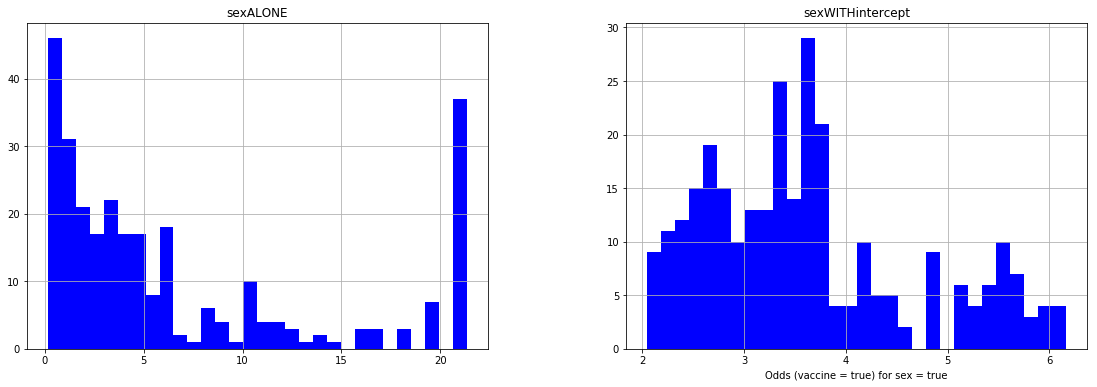

In [83]:
import numpy as np

draw = pd.DataFrame(np.exp(sex), columns=['sexALONE','sexWITHintercept'])
draw.hist(figsize = (19,6), color = 'b', bins = 30)
plt.xlabel('Odds (vaccine = true) for sex = true')
plt.show()

How the Odds Ratio varies thoughout the simulation?

In [84]:
sum(df.loc[df.step == 40, ['sex']].values * df.loc[df.step == 40, ['vaccine']].values)

array([95])

In [85]:
sum(np.invert(df.loc[df.step == 40, ['sex']].values) * df.loc[df.step == 40, ['vaccine']].values)

array([47])

In [86]:
i = 0
ratio = []

while i < 299:
    try:
        sexVaccine = sum(df.loc[df.step == i, ['sex']].values * df.loc[df.step == i, ['vaccine']].values)[0]
        NoSexVaccine = sum(np.invert(df.loc[df.step == i, ['sex']].values) * df.loc[df.step == i, ['vaccine']].values)[0]
        
        ratio.append([i, sexVaccine/NoSexVaccine])
        i +=1
    except:
        print('No enough sex 0 with vaccine')
        i +=1

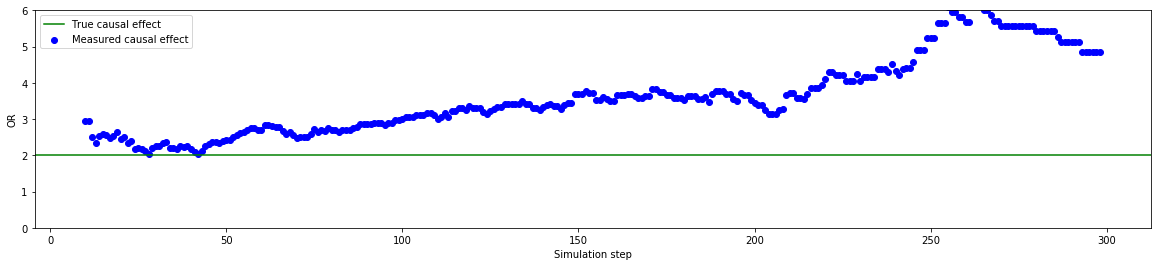

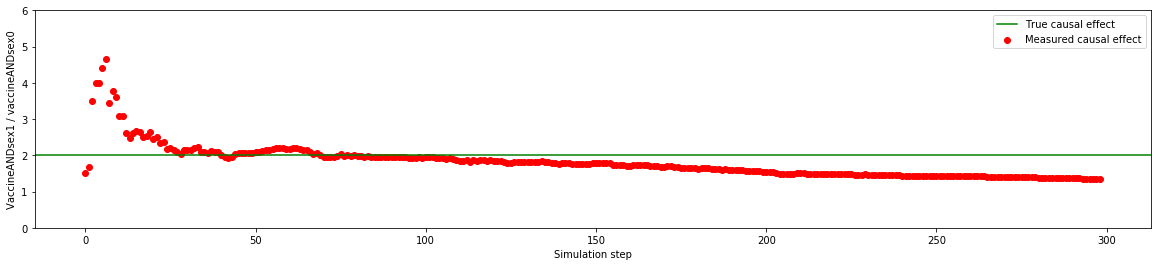

In [91]:
draw2 = pd.DataFrame(sexTime, columns = ['step','coef'])
draw3 = pd.DataFrame(ratio, columns = ['step','ratio'])

figsize = (20,4)

plt.figure(figsize=figsize)
plt.scatter(draw2.step, np.exp(draw2.coef), color = 'b', label = 'Measured causal effect')
plt.axhline(2, color = 'green', label = 'True causal effect')
plt.xlabel('Simulation step')
plt.ylabel('OR')
plt.ylim(0,6)
plt.legend()
plt.show()

plt.figure(figsize=figsize)
plt.scatter(draw3.step, draw3.ratio, color = 'r', label = 'Measured causal effect')
plt.axhline(2, color = 'green', label = 'True causal effect')
plt.xlabel('Simulation step')
plt.ylabel('VaccineANDsex1 / vaccineANDsex0')
plt.ylim(0,6)
plt.legend()
plt.show()

The `sexALONE` graph is wrong.

What is the mean causal effect and the CI?

In [88]:
import numpy as np
import scipy as sp
import scipy.stats

def meanCI(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m, m+h

print('CI and mean for OR:')
print(meanCI(draw.sexWITHintercept))
print('\nCI and mean for ratio:')
print(meanCI(draw3.ratio[10:]))

CI and mean for OR:
(3.497314398187513, 3.6187548626346415, 3.74019532708177)

CI and mean for ratio:
(1.727074720088913, 1.7642660062872517, 1.8014572924855905)


In [89]:
def OR(prob, causal):
    this = (causal * prob * (1 - prob)) /( prob * (1 - causal * prob))
    return this

In [90]:
OR(0.001, 2)

2.002004008016032